In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = '/content/drive/MyDrive/PCB_DATASET'

In [ ]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.1/873.1 kB 47.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
import xml.etree.ElementTree as ET
import yaml
from pathlib import Path
from collections import Counter

from ultralytics import YOLO
from sklearn.model_selection import KFold

In [ ]:
dataset_dir = root_dir

for root, dirs, files in os.walk(dataset_dir):
   for name in dirs:
      print(os.path.join(root, name))

/content/drive/MyDrive/PCB_DATASET/Annotations
/content/drive/MyDrive/PCB_DATASET/images
/content/drive/MyDrive/PCB_DATASET/rotation
/content/drive/MyDrive/PCB_DATASET/PCB_USED
/content/drive/MyDrive/PCB_DATASET/Annotations/Open_circuit
/content/drive/MyDrive/PCB_DATASET/Annotations/Missing_hole
/content/drive/MyDrive/PCB_DATASET/Annotations/Spurious_copper
/content/drive/MyDrive/PCB_DATASET/Annotations/Spur
/content/drive/MyDrive/PCB_DATASET/Annotations/Mouse_bite
/content/drive/MyDrive/PCB_DATASET/Annotations/Short
/content/drive/MyDrive/PCB_DATASET/images/Spurious_copper
/content/drive/MyDrive/PCB_DATASET/images/Short
/content/drive/MyDrive/PCB_DATASET/images/Spur
/content/drive/MyDrive/PCB_DATASET/images/Open_circuit
/content/drive/MyDrive/PCB_DATASET/images/Mouse_bite
/content/drive/MyDrive/PCB_DATASET/images/Missing_hole
/content/drive/MyDrive/PCB_DATASET/rotation/Mouse_bite_rotation
/content/drive/MyDrive/PCB_DATASET/rotation/Spur_rotation
/content/drive/MyDrive/PCB_DATASET/rota

In [ ]:
def count_files_in_folder(folder_path):
    # Get list of all files in the folder
    files = os.listdir(folder_path)

    # Count the number of files
    num_files = len(files)

    return num_files

In [ ]:
subfolders = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

images_dir = os.path.join(dataset_dir, 'images')
annot_dir = os.path.join(dataset_dir, 'Annotations')

for subfolder in subfolders:
    images_path = os.path.join(images_dir, subfolder)
    annot_path = os.path.join(annot_dir, subfolder)

    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')

Missing_hole    	            115 images 	            115 annotations
Mouse_bite      	            115 images 	            115 annotations
Open_circuit    	            116 images 	            116 annotations
Short           	            116 images 	            116 annotations
Spur            	            115 images 	            115 annotations
Spurious_copper 	            116 images 	            116 annotations


In [ ]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    data = []

    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return data

In [ ]:
# List to store parsed data from all XML files
all_data = []

# Recursively traverse subdirectories
for root, dirs, files in os.walk(annot_dir):
    for name in files:
        if name.endswith('.xml'):
            xml_path = os.path.join(root, name)
            all_data.extend(parse_xml(xml_path))

In [ ]:
# Create DataFrame from the parsed data
annot_df = pd.DataFrame(all_data)
annot_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,01_open_circuit_05.jpg,3034,1586,open_circuit,2204,604,2236,641
1,01_open_circuit_05.jpg,3034,1586,open_circuit,1015,1312,1050,1349
2,01_open_circuit_05.jpg,3034,1586,open_circuit,2713,946,2746,979
3,04_open_circuit_04.jpg,3056,2464,open_circuit,395,506,455,564
4,04_open_circuit_04.jpg,3056,2464,open_circuit,1797,815,1866,859


In [ ]:
def get_subfolder(image_name):
    if 'missing' in image_name.split('_'):
        return 'Missing_hole'
    if 'mouse' in image_name.split('_'):
        return'Mouse_bite'
    if 'open' in image_name.split('_'):
        return 'Open_circuit'
    if 'short' in image_name.split('_'):
        return 'Short'
    if 'spur' in image_name.split('_'):
        return 'Spur'
    if 'spurious' in image_name.split('_'):
        return 'Spurious_copper'

In [ ]:
def visualize_annotations(image_name, images_dir, annot_df, is_subfolder=False):
    # Construct path for image
    if is_subfolder:
        image_path = os.path.join(images_dir, get_subfolder(image_name), image_name)
    else:
        image_path = os.path.join(images_dir, image_name)


    # Read image
    image = cv2.imread(image_path)

    # Filter annotations for the current image
    annotations = annot_df[annot_df['filename'] == image_name]

    # Draw bounding boxes on the image
    for _, annot in annotations.iterrows():
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']
        class_label = annot['class']

        # Check if confidence column exists
        confidence = annot.get('confidence')
        if confidence is not None:
            class_label += f" ({confidence:.2f})"

        color = (255, 255, 255)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 3)

        # Add background to the text
        text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)[0]
        cv2.rectangle(image, (xmin, ymin - text_size[1] - 5),
                             (xmin + text_size[0], ymin - 1), color, -1)

        # Add text
        cv2.putText(image, class_label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)

    # Convert BGR image to RGB (Matplotlib expects RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image with annotations
    plt.figure(figsize=(18, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Annotations')
    plt.text(10, image_rgb.shape[0] + 100, f'Image: {image_name}',
             color='black', fontsize=11, ha='left')
    plt.show()

    return image

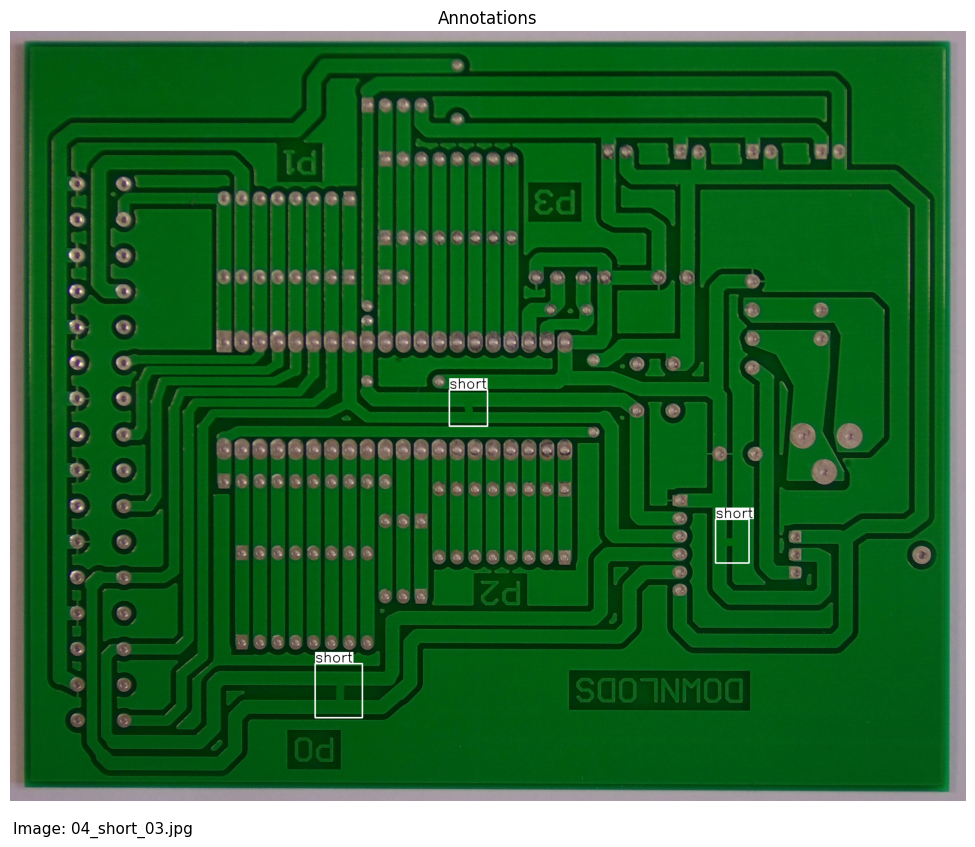

In [ ]:
image_name = '04_short_03.jpg'
visualize_annotations(image_name, images_dir, annot_df, is_subfolder=True);

In [ ]:
def resize_images(input_dir, output_dir, target_size=(640, 640)):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Traverse through the subfolders in the input folder
    for root, _, files in os.walk(input_dir):
        for file in files:
            # Check if the file is an image
            if file.lower().endswith(('.jpg')):
                # Read the image
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)

                # Resize the image
                resized_image = cv2.resize(image, target_size)

                # Save the resized image to the output folder
                output_path = os.path.join(output_dir, file)
                cv2.imwrite(output_path, resized_image)

resized_img_dir = os.path.join(dataset_dir, 'images_resized')
resize_images(images_dir, resized_img_dir)

In [ ]:
def resize_annotations(annot_df, target_size=(640, 640)):
    all_data = []

    # Iterate through the annotation DataFrame
    for index, row in annot_df.iterrows():

        # Resize the bounding box coordinates
        width_ratio = target_size[0] / row['width']
        height_ratio = target_size[1] / row['height']

        resized_xmin = int(row['xmin'] * width_ratio)
        resized_ymin = int(row['ymin'] * height_ratio)
        resized_xmax = int(row['xmax'] * width_ratio)
        resized_ymax = int(row['ymax'] * height_ratio)

        # Update the all data list with resized annotations
        all_data.append({
            'filename': row['filename'],
            'width': target_size[0],
            'height': target_size[1],
            'class': row['class'],
            'xmin': resized_xmin,
            'ymin': resized_ymin,
            'xmax': resized_xmax,
            'ymax': resized_ymax
        })

    annot_df_resized = pd.DataFrame(all_data)
    return annot_df_resized

annot_df_resized = resize_annotations(annot_df)
annot_df_resized.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,01_open_circuit_05.jpg,640,640,open_circuit,464,243,471,258
1,01_open_circuit_05.jpg,640,640,open_circuit,214,529,221,544
2,01_open_circuit_05.jpg,640,640,open_circuit,572,381,579,395
3,04_open_circuit_04.jpg,640,640,open_circuit,82,131,95,146
4,04_open_circuit_04.jpg,640,640,open_circuit,376,211,390,223


In [ ]:
# Create the output directory
output_dir = os.path.join(dataset_dir, 'output')
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Convert annotation DataFrame into YOLO labels
# YOLO format: <class_index> <x_center> <y_center> <width> <height>
def convert_to_yolo_labels(annotation_df, classes, target_size=(640, 640)):
    yolo_labels = []

    for _, annot in annotation_df.iterrows():
        filename = annot['filename']
        width, height = annot['width'], annot['height']
        class_name = annot['class']
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']

        # Convert bounding box coordinates to YOLO format
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        class_index = classes.index(class_name)

        # Append to YOLO labels list
        yolo_labels.append((filename, class_index, x_center, y_center, bbox_width, bbox_height))

    return yolo_labels


classes = ['missing_hole', 'mouse_bite', 'open_circuit',
           'short', 'spur', 'spurious_copper']
yolo_labels = convert_to_yolo_labels(annot_df_resized, classes)

In [ ]:
def split_images_and_labels(images_dir, labels, output_dir, train_split=0.95, val_split=0.05):
    # os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/test'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/test'), exist_ok=True)

    # Group labels by image filename
    image_labels = {}
    for label in labels:
        filename, class_index, x_center, y_center, bbox_width, bbox_height = label
        if filename not in image_labels:
            image_labels[filename] = []
        image_labels[filename].append(label)

    # Shuffle the image filenames
    image_filenames = list(image_labels.keys())
    random.shuffle(image_filenames)

    # Split the dataset
    num_images = len(image_filenames)
    num_train = int(num_images * train_split)
    num_val = int(num_images * val_split)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train + num_val]
    test_filenames = image_filenames[num_train + num_val:]

    # Write train, val, test images and labels
    for dataset, filenames in [('train', train_filenames), ('val', val_filenames), ('test', test_filenames)]:
        for filename in filenames:
            labels = image_labels[filename]
            with open(os.path.join(output_dir, f'labels/{dataset}/{os.path.splitext(filename)[0]}.txt'), 'a') as label_file:
                for label in labels:
                    _, class_index, x_center, y_center, bbox_width, bbox_height = label
                    label_file.write(f"{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n")
            # Copy images to corresponding folders
            shutil.copy(os.path.join(images_dir, filename), os.path.join(output_dir, f'images/{dataset}/{filename}'))

split_images_and_labels(resized_img_dir, yolo_labels, output_dir)

In [ ]:
dataset_path = Path(output_dir)
labels = sorted(dataset_path.rglob("*labels/train/*.txt")) # all data in 'labels'

In [ ]:
cls_idx = list(range(len(classes)))
print(list(zip(classes, cls_idx)))

[('missing_hole', 0), ('mouse_bite', 1), ('open_circuit', 2), ('short', 3), ('spur', 4), ('spurious_copper', 5)]


In [ ]:
indx = [l.stem for l in labels] # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [ ]:
for label in labels:
    lbl_counter = Counter()

    with open(label,'r') as lf:
        lines = lf.readlines()

    for l in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(l.split(' ')[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`
labels_df.head()

,0,1,2,3,4,5
01_missing_hole_01,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_02,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_03,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_04,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_05,4.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ksplit = 3
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)   # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [ ]:
folds = [f'split_{n}' for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
    folds_df[f'split_{idx}'].loc[labels_df.iloc[val].index] = 'val'

In [ ]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1E-7)
    fold_lbl_distrb.loc[f'split_{n}'] = ratio

fold_lbl_distrb

,0,1,2,3,4,5
split_1,0.376471,0.503268,0.369822,0.416928,0.751825,0.567657
split_2,0.529412,0.654676,0.558923,0.486842,0.395349,0.517572
split_3,0.613793,0.369048,0.591065,0.608541,0.403509,0.422156


In [ ]:
# Initialize a list to store image file paths
images = sorted(dataset_path.rglob("*images/train/*.jpg"))

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f'{ksplit}fold_crossval')
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f'{split}_dataset.yaml'
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, 'w') as ds_y:
        yaml.safe_dump({
            'path': split_dir.as_posix(),
            'train': 'train',
            'val': 'val',
            'names': classes
        }, ds_y)

In [ ]:
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / 'images'
        lbl_to_path = save_path / split / k_split / 'labels'

        # Copy image and label files to new directory
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [ ]:
folds_df.to_csv(save_path / "kfold_datasplit.csv")
fold_lbl_distrb.to_csv(save_path / "kfold_label_distribution.csv")

In [ ]:
# Train the model
model = YOLO('yolov8s.pt')
results = {}

# Additional arguments here
batch = 16
project = 'pcb'
epochs = 180
imgsz=640
save_period=1
verbose=True
# box=6.0 # Weight of the box loss component in the loss function
# cls = 2.0 # Weight of the classification loss in the total loss function
mixup = 0.3 # Blends two images and their labels, creating a composite image

for k in range(ksplit):
    dataset_yaml = ds_yamls[k]
    model.train(data=dataset_yaml,
                epochs=epochs,
                batch=batch,
                lr0=0.001,
                lrf=0.0001,
                imgsz=imgsz,
                save_period=save_period,
                verbose=verbose,
                project=project,
                mixup=mixup)
    results[k] = model.metrics

100%|██████████| 21.5M/21.5M [00:00<00:00, 475MB/s]


Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/split_1_dataset.yaml, epochs=180, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=pcb, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False

100%|██████████| 755k/755k [00:00<00:00, 88.8MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 396MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/train/labels... 438 images, 0 backgrounds, 0 corrupt: 100%|██████████| 438/438 [00:01<00:00, 249.72it/s]


train: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/val/labels... 220 images, 0 backgrounds, 0 corrupt: 100%|██████████| 220/220 [00:02<00:00, 100.46it/s]


val: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/val/labels.cache
Plotting labels to pcb/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to pcb/train
Starting training for 180 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/180      3.99G      4.106      23.65      2.082         54        640: 100%|██████████| 28/28 [00:08<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]

                   all        220        918   0.000191     0.0547   0.000129   6.26e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/180      4.08G      3.228       4.69      1.391         32        640: 100%|██████████| 28/28 [00:06<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        220        918      0.271      0.188     0.0402     0.0159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/180      4.05G      2.775      3.259      1.245         34        640: 100%|██████████| 28/28 [00:06<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        220        918       0.26      0.355      0.212     0.0838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/180      4.05G      2.589      2.846      1.183         41        640: 100%|██████████| 28/28 [00:06<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        220        918      0.451      0.387      0.347      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/180      4.06G      2.551      2.564      1.153         64        640: 100%|██████████| 28/28 [00:06<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        220        918      0.513      0.455      0.462      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/180      3.97G      2.429      2.371      1.106         30        640: 100%|██████████| 28/28 [00:06<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        220        918       0.58       0.54      0.529      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/180      4.05G      2.277      2.081      1.096         55        640: 100%|██████████| 28/28 [00:06<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        220        918      0.712      0.492      0.569      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/180      4.01G      2.222      1.982      1.079         63        640: 100%|██████████| 28/28 [00:06<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        220        918      0.759      0.637      0.683      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/180      4.05G       2.27      1.893      1.096         48        640: 100%|██████████| 28/28 [00:06<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        220        918      0.816      0.622      0.711      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/180      4.05G      2.232      1.882       1.07         37        640: 100%|██████████| 28/28 [00:06<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        220        918      0.831      0.632      0.698      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/180      4.02G      2.191      1.774      1.058         49        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        220        918       0.89      0.678      0.775       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/180      4.05G      2.156      1.727      1.053         38        640: 100%|██████████| 28/28 [00:06<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        220        918      0.887      0.654      0.767       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/180      4.05G      2.183      1.692      1.056         48        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        220        918      0.914      0.682      0.793      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/180      4.05G      2.153      1.658      1.047         39        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        220        918      0.797      0.693       0.79      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/180      4.02G        2.1      1.631      1.047         37        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        220        918      0.887      0.706      0.804       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/180      4.05G      2.083      1.555      1.037         37        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        220        918      0.878      0.729      0.799      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/180      4.04G      2.037      1.499      1.021         61        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        220        918       0.88      0.774      0.832      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/180      4.01G      2.074      1.497      1.028         55        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        220        918      0.875       0.75       0.83      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/180      4.01G      2.035       1.48      1.024         56        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        220        918      0.882      0.764       0.84      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/180      4.02G      2.009      1.425      1.027         40        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        220        918      0.913      0.716      0.811      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/180      4.02G       2.01      1.454      1.016         55        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        220        918      0.896      0.771      0.845      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/180      4.05G      2.033      1.484      1.027         68        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        220        918      0.915      0.752      0.829      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/180      4.01G      1.968      1.412      1.014         30        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        220        918      0.834      0.756       0.81      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/180      4.05G      1.993       1.42      1.025         43        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        220        918      0.921      0.762      0.842      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/180      3.97G      1.932       1.36     0.9856         46        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        220        918       0.92      0.778      0.852      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/180      4.02G      1.937      1.358       1.01         40        640: 100%|██████████| 28/28 [00:07<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        220        918      0.932      0.776      0.853      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/180      4.04G      1.973      1.419      1.016         41        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        220        918       0.91      0.791      0.865      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/180      3.98G      1.962      1.395      1.015         44        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        220        918      0.895      0.808      0.863      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/180      4.04G      1.958      1.367      0.995         37        640: 100%|██████████| 28/28 [00:07<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        220        918      0.909      0.795      0.852      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/180      4.05G      1.944      1.361      1.002         52        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        220        918      0.905      0.813      0.876      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/180      4.04G      1.922      1.303     0.9937         30        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        220        918       0.93      0.792      0.866      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/180      4.02G      1.972      1.388     0.9977         52        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        220        918      0.921      0.799      0.879      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/180      4.04G       1.93      1.297      1.003         19        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        220        918      0.885      0.787      0.862      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/180      4.02G      1.914      1.299     0.9986         31        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        220        918      0.918      0.825       0.87      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/180      4.01G      1.886      1.252      0.984         53        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        220        918      0.921      0.804      0.872      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/180      4.02G      1.949      1.321     0.9974         40        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        220        918      0.947      0.768      0.867       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/180      3.97G      1.889      1.298      0.989         49        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        220        918      0.953      0.802      0.882      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/180      4.01G      1.889      1.236     0.9801         27        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        220        918      0.883      0.824       0.88      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/180      4.02G      1.856      1.221      0.975         75        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        220        918      0.905      0.829       0.89      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/180      4.02G      1.852      1.239     0.9858         29        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        220        918      0.903      0.824      0.873      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/180      4.04G      1.849        1.2     0.9826         47        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        220        918       0.93      0.813      0.876      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/180      4.02G      1.875      1.284      0.982         43        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        220        918      0.945      0.799      0.877      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/180      4.02G      1.817      1.241     0.9836         41        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        220        918      0.932      0.821      0.881      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/180      4.04G      1.844      1.223     0.9753         54        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        220        918      0.937      0.828       0.88      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/180      3.98G      1.863      1.214     0.9746         57        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        220        918      0.948      0.842      0.895      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/180      4.02G      1.841      1.225       0.97         49        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        220        918       0.92      0.827      0.894      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/180      4.01G      1.844      1.226     0.9711         32        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        220        918      0.919      0.803      0.873      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/180      4.05G      1.854      1.227     0.9716         56        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        220        918      0.934      0.832      0.893      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/180      4.04G      1.823      1.222     0.9776         21        640: 100%|██████████| 28/28 [00:07<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        220        918      0.932      0.823      0.888      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/180      3.97G      1.816      1.179     0.9561         30        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        220        918      0.934      0.839        0.9      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/180      4.02G      1.827      1.207     0.9622         25        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        220        918      0.935      0.792       0.89      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/180      4.02G      1.846      1.179     0.9631         61        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        220        918      0.952       0.83      0.898      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/180      4.04G      1.828      1.168     0.9614         46        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        220        918      0.926       0.84      0.902      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/180      4.04G      1.779      1.126     0.9577         46        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        220        918      0.944      0.825      0.899      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/180      4.02G      1.804      1.151     0.9706         28        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        220        918      0.945      0.813      0.896      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/180      3.97G       1.76      1.186     0.9494         64        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        220        918      0.919      0.819      0.897      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/180      4.02G       1.76      1.152     0.9577         45        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        220        918      0.916      0.836       0.89      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/180      3.97G      1.758       1.16     0.9518         44        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        220        918      0.941       0.84       0.89      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/180      4.01G      1.787      1.133     0.9536         32        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        220        918       0.93      0.854      0.904       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/180      4.05G      1.794      1.164     0.9594         79        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        220        918      0.908      0.843      0.907      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/180      4.02G      1.742      1.133     0.9458         36        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        220        918      0.938      0.862       0.91      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/180      4.02G      1.736      1.099     0.9508         43        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        220        918      0.956      0.831      0.901      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/180      4.04G      1.733      1.105     0.9578         61        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        220        918      0.921      0.847      0.909      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/180      4.05G       1.74      1.127     0.9513         40        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        220        918       0.95      0.825      0.897       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/180      4.05G      1.772      1.112     0.9617         53        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        220        918       0.93      0.844      0.904      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/180      4.05G      1.742      1.115     0.9525         46        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        220        918      0.936      0.852      0.907      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/180      4.01G       1.72      1.092     0.9447         49        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        220        918      0.947      0.854      0.917      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/180      4.02G      1.715      1.096     0.9366         78        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        220        918       0.93      0.857      0.909      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/180      4.05G      1.746      1.122     0.9454         73        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        220        918      0.958      0.855      0.917      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/180      4.05G      1.733      1.078     0.9511         45        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        220        918      0.925      0.838      0.905      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/180      4.01G      1.722        1.1     0.9446         48        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        220        918      0.937      0.848      0.905      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/180      3.99G      1.748        1.1     0.9561         30        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        220        918      0.928      0.858      0.906      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/180      4.05G      1.699      1.043     0.9401         33        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        220        918      0.937      0.859      0.911       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/180      4.02G      1.691      1.063     0.9403         33        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        220        918      0.959      0.836      0.905      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/180      4.05G      1.675      1.023     0.9365         31        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        220        918      0.928      0.864      0.913       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/180      4.02G      1.712      1.099     0.9351         50        640: 100%|██████████| 28/28 [00:07<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        220        918      0.953      0.861      0.917      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/180      3.97G      1.697      1.037     0.9416         48        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        220        918      0.955      0.857      0.915      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/180      4.04G      1.693      1.072     0.9402         36        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        220        918      0.931      0.866      0.913      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/180      4.04G      1.666      1.046      0.926         43        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        220        918       0.94      0.855      0.913      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/180      4.01G      1.677      1.045     0.9377         49        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        220        918      0.939      0.861      0.921      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/180      4.01G      1.672      1.018     0.9389         37        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        220        918      0.947      0.855      0.922      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/180      4.05G       1.66      1.034     0.9304         42        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        220        918      0.955       0.86      0.918      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/180      4.04G      1.663      1.027     0.9382         36        640: 100%|██████████| 28/28 [00:07<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        220        918      0.937      0.878      0.923      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/180      4.05G      1.663      1.019     0.9369         42        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        220        918      0.949      0.849      0.911      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/180      4.04G      1.663      1.022     0.9372         48        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        220        918      0.942      0.876       0.92      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/180      4.02G      1.658      1.005     0.9247         41        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        220        918      0.943      0.872      0.923      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/180      4.02G      1.622     0.9836     0.9225         42        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        220        918      0.953       0.86      0.917      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/180      4.05G      1.614     0.9829     0.9262         62        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        220        918      0.955      0.874      0.924      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/180      4.04G      1.646     0.9962     0.9234         29        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        220        918       0.96      0.872      0.922      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/180      4.05G      1.611     0.9509      0.919         39        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        220        918      0.952      0.865      0.921      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/180      4.01G      1.612     0.9979     0.9357         51        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        220        918      0.964       0.83      0.918      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/180      3.97G      1.642       1.03     0.9336         34        640: 100%|██████████| 28/28 [00:07<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        220        918       0.93      0.857      0.923      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/180      4.04G       1.64     0.9999     0.9348         57        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        220        918      0.935      0.878      0.927      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/180      4.02G      1.688       1.04     0.9257         42        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        220        918      0.955      0.865      0.919      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/180      4.05G      1.657      0.983     0.9185         50        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        220        918      0.974      0.871       0.93       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/180      4.04G      1.599     0.9485     0.9098         23        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        220        918      0.961      0.874       0.93      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/180      4.02G      1.581     0.9679     0.9219         44        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        220        918      0.967      0.876       0.93       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/180      4.03G      1.576     0.9624     0.9153         44        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        220        918      0.956      0.869      0.931      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/180      4.05G      1.673       1.05     0.9238         46        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        220        918      0.939      0.877      0.922      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/180      4.05G      1.643      1.039     0.9245         44        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        220        918      0.955      0.884      0.928      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/180      4.01G      1.605      1.009     0.9164         49        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        220        918      0.941      0.887       0.93      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/180      4.05G      1.595     0.9795     0.9183         31        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        220        918      0.931      0.896      0.932      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/180      4.01G      1.583      0.963     0.9156         44        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        220        918      0.974      0.867      0.934      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/180      3.97G      1.567     0.9752     0.9218         54        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        220        918      0.972       0.86      0.926      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/180      4.04G      1.634          1     0.9262         31        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        220        918      0.958      0.874      0.919       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/180      4.04G      1.617     0.9871     0.9233         29        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        220        918      0.965      0.869       0.93      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/180      4.04G      1.597     0.9628     0.9184         58        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        220        918      0.956      0.887      0.932      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/180      4.04G      1.557     0.9405     0.9157         39        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        220        918      0.954      0.879      0.932      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/180      4.05G      1.548     0.9199     0.9082         45        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        220        918      0.959      0.884      0.935      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/180      4.05G       1.54       0.92     0.9078         46        640: 100%|██████████| 28/28 [00:07<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        220        918       0.95      0.888      0.939      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/180      4.05G      1.554     0.9273     0.9049         22        640: 100%|██████████| 28/28 [00:07<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        220        918      0.961       0.88      0.934      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/180      4.01G      1.565     0.9723     0.9116         31        640: 100%|██████████| 28/28 [00:07<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        220        918      0.967      0.865      0.928       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/180      4.04G      1.557     0.9628     0.9104         25        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        220        918      0.956      0.887      0.933      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/180      4.01G       1.53     0.9353     0.9132         49        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        220        918      0.945      0.874      0.921      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/180      4.02G      1.561     0.9451     0.9131         57        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        220        918      0.955      0.886      0.931      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/180      4.02G      1.534     0.9114     0.9069         23        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        220        918      0.945       0.89      0.929      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/180      4.04G      1.543     0.9217     0.9094         38        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        220        918      0.967      0.872      0.936      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/180      4.05G      1.528     0.9051     0.9066         58        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        220        918      0.963      0.879      0.936      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/180      4.04G       1.52     0.9307     0.9073         40        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        220        918      0.956      0.884       0.93      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/180      4.05G      1.565     0.9433     0.9186         40        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        220        918      0.968      0.861      0.933      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/180      4.04G      1.554     0.9452     0.9069         51        640: 100%|██████████| 28/28 [00:07<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        220        918      0.966      0.871      0.933      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/180      4.04G      1.547     0.9388     0.9018         53        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        220        918      0.952      0.884      0.932      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/180      3.97G      1.485     0.8883     0.9093         40        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        220        918      0.954       0.88       0.93      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/180      4.05G      1.525     0.9074     0.9012         32        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        220        918      0.962      0.894      0.936      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/180      4.04G      1.503     0.8977     0.9042         48        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        220        918      0.965      0.875      0.936      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/180      4.05G      1.486     0.8736      0.897         35        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        220        918       0.96      0.869       0.93      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/180      4.01G      1.465     0.8715     0.8926         18        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        220        918      0.958      0.875      0.934      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/180      4.05G      1.488     0.8894     0.9057         57        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        220        918      0.963      0.878      0.936      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/180      4.01G      1.472     0.8538     0.8954         58        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        220        918      0.964      0.873      0.937      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/180      4.05G      1.464     0.8956     0.9054         30        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        220        918       0.93      0.893      0.937      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/180      4.02G      1.478     0.8975     0.8887         64        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        220        918      0.955       0.89      0.938      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/180      4.01G      1.487     0.8678     0.9044         38        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        220        918      0.958      0.896      0.942      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/180      4.04G      1.468      0.877      0.906         32        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        220        918      0.949      0.886      0.934      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/180      4.01G      1.464     0.8564     0.9023         34        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        220        918      0.943      0.898      0.941      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/180      3.97G      1.482     0.9047      0.912         60        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        220        918      0.958       0.89      0.938      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/180      4.05G      1.468     0.8711      0.897         47        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        220        918      0.965      0.884      0.933      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/180      4.01G      1.471     0.8892     0.9092         48        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        220        918      0.959      0.887      0.936      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/180      4.01G      1.433      0.828     0.8915         47        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        220        918      0.962      0.881      0.932      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/180      4.01G      1.527     0.9592     0.9049         57        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        220        918      0.947      0.891      0.932      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/180      4.05G      1.465     0.8798     0.8985         22        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        220        918      0.963      0.886      0.935      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/180      4.05G      1.427     0.8296     0.8852         69        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        220        918      0.964      0.873      0.937      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/180      4.02G      1.452     0.8616     0.8908         37        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        220        918      0.966      0.866      0.936      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/180      4.01G      1.429      0.856      0.895         48        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        220        918      0.976      0.876      0.942      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/180      3.97G       1.41     0.8331     0.8953         30        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        220        918      0.971      0.874      0.937      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/180      4.04G      1.415     0.8382     0.8862         33        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        220        918      0.956      0.892       0.94      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/180      4.05G      1.443     0.8978     0.8953         64        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        220        918      0.952      0.892      0.939      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/180      3.97G      1.462     0.8995     0.8987         53        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        220        918      0.962      0.885      0.937      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/180      4.05G      1.453     0.8685     0.8898         63        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        220        918      0.964      0.879      0.938      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/180      4.04G      1.386      0.826     0.8906         34        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        220        918      0.963      0.881      0.936      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/180      4.03G       1.43     0.8663     0.8911         78        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        220        918      0.959      0.874      0.936      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/180      4.01G      1.461     0.8882     0.8902         67        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        220        918      0.944      0.884      0.937      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/180      4.04G      1.384     0.8121     0.8881         39        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        220        918       0.96      0.875      0.934      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/180      4.01G      1.385     0.8474     0.8868         30        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        220        918      0.965      0.884      0.941      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/180      4.05G      1.367     0.8111     0.8851         28        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        220        918      0.956      0.898      0.944      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/180      3.97G      1.387      0.822       0.89         58        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        220        918      0.958      0.888      0.942      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/180      4.01G      1.381     0.8331     0.8953         49        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        220        918      0.942      0.893      0.943      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/180      4.04G       1.36     0.8214     0.8861         58        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        220        918      0.949      0.894      0.944      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/180      4.05G      1.402     0.8485     0.8868         58        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        220        918      0.942      0.897      0.938      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/180      4.01G      1.357     0.7912     0.8806         49        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        220        918      0.969      0.883      0.941      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/180      4.02G       1.36     0.8244      0.876         36        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        220        918      0.955      0.885      0.941      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/180      4.01G      1.372     0.8148     0.8877         58        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        220        918      0.953      0.896      0.942      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/180      4.03G      1.368     0.7958     0.8879         43        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        220        918      0.966      0.878      0.944      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/180      4.01G      1.371     0.8114     0.8842         52        640: 100%|██████████| 28/28 [00:07<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        220        918      0.964      0.875      0.939      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/180      4.03G      1.304     0.7586     0.8789         54        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        220        918      0.961      0.881       0.94      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/180      4.04G      1.378     0.8372     0.8897         44        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        220        918      0.962      0.882      0.938      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/180      4.05G       1.35     0.8062     0.8793         43        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        220        918      0.958      0.886      0.943      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/180      4.01G      1.348     0.8101     0.8909         53        640: 100%|██████████| 28/28 [00:07<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        220        918      0.962      0.879      0.943       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/180      4.01G      1.312     0.7604     0.8701         65        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        220        918      0.952      0.891      0.944      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/180      4.04G      1.326     0.8029     0.8846         24        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        220        918      0.951       0.89      0.944      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/180      4.05G      1.323     0.7804     0.8789         57        640: 100%|██████████| 28/28 [00:06<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        220        918      0.957      0.891      0.947      0.486


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/180         4G      1.103     0.5473     0.8483         21        640: 100%|██████████| 28/28 [00:08<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        220        918      0.962      0.886      0.938      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/180         4G      1.084     0.5349     0.8499         21        640: 100%|██████████| 28/28 [00:06<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        220        918      0.966      0.881      0.934      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/180         4G      1.067      0.526      0.851         22        640: 100%|██████████| 28/28 [00:06<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        220        918      0.965      0.884      0.938      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/180         4G      1.073      0.526      0.854         28        640: 100%|██████████| 28/28 [00:06<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        220        918      0.961      0.884      0.937      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/180         4G      1.046     0.5239     0.8472         28        640: 100%|██████████| 28/28 [00:06<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        220        918      0.955      0.888      0.936      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/180         4G      1.051     0.5214     0.8445         27        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        220        918       0.96      0.889      0.937      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/180         4G      1.078     0.5301     0.8518         28        640: 100%|██████████| 28/28 [00:06<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        220        918      0.956      0.889      0.939      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/180         4G      1.051     0.5125     0.8477         26        640: 100%|██████████| 28/28 [00:06<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        220        918      0.954      0.889      0.939       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/180         4G      1.052     0.5091     0.8458         24        640: 100%|██████████| 28/28 [00:06<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        220        918       0.96      0.889       0.94      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/180         4G      1.038     0.5097     0.8467         24        640: 100%|██████████| 28/28 [00:06<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        220        918      0.962      0.887       0.94      0.482



180 epochs completed in 0.489 hours.
Optimizer stripped from pcb/train/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train/weights/best.pt, 22.5MB

Validating pcb/train/weights/best.pt...
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


                   all        220        918      0.957      0.891      0.947      0.487
          missing_hole         31        128      0.999          1      0.995      0.594
            mouse_bite         38        154      0.895      0.792      0.899      0.448
          open_circuit         30        125      0.933      0.848      0.929      0.449
                 short         33        133      0.992      0.982      0.987      0.481
                  spur         48        206      0.982      0.777      0.905      0.456
       spurious_copper         40        172      0.942      0.945      0.967      0.493
Speed: 0.2ms preprocess, 4.6ms inference, 0.1ms loss, 6.8ms postprocess per image
Results saved to pcb/train
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/split_2_dataset.yaml, epochs=180, time=None, patienc

train: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/train/labels... 439 images, 0 backgrounds, 0 corrupt: 100%|██████████| 439/439 [00:01<00:00, 251.78it/s]


train: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/val/labels... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:01<00:00, 119.17it/s]


val: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/val/labels.cache
Plotting labels to pcb/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to pcb/train2
Starting training for 180 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/180       4.3G      1.607     0.9658     0.9216         65        640: 100%|██████████| 28/28 [00:07<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        219        956       0.99      0.972      0.988      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/180      4.14G      1.656      1.038     0.9335         48        640: 100%|██████████| 28/28 [00:07<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        219        956      0.978      0.969      0.981      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/180      4.12G      1.692      1.058     0.9395         37        640: 100%|██████████| 28/28 [00:07<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        219        956      0.983       0.94      0.972      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/180      4.09G      1.731      1.086     0.9339         53        640: 100%|██████████| 28/28 [00:07<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        219        956      0.983       0.95      0.975      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/180      4.06G      1.741      1.134     0.9443         85        640: 100%|██████████| 28/28 [00:07<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        219        956      0.983      0.946      0.978      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/180      4.09G      1.708      1.105     0.9444         47        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        219        956      0.963      0.958      0.978       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/180       4.1G      1.704      1.089     0.9433         60        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        219        956      0.977      0.949      0.972      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/180      4.09G      1.693      1.091     0.9345         63        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        219        956      0.977      0.943      0.974      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/180       4.1G      1.731      1.108     0.9519         39        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        219        956      0.977      0.936      0.976      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/180      4.06G      1.759      1.105     0.9546         52        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        219        956      0.952      0.944      0.971      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/180      4.08G      1.723      1.113     0.9457         64        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        219        956      0.972      0.951      0.978      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/180      4.07G      1.702      1.112     0.9381         58        640: 100%|██████████| 28/28 [00:07<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        219        956      0.958      0.956      0.975      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/180       4.1G       1.69      1.063     0.9407         55        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        219        956      0.967      0.955      0.968      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/180      4.09G      1.676      1.067     0.9386         61        640: 100%|██████████| 28/28 [00:07<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        219        956      0.969      0.939      0.974      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/180       4.1G      1.679       1.07      0.949         39        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        219        956      0.972      0.947      0.966      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/180      4.06G      1.737      1.126      0.945         81        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        219        956      0.979      0.936      0.968      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/180      4.07G      1.665      1.049     0.9342         65        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        219        956      0.978      0.942       0.97      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/180      4.09G      1.664      1.063     0.9341         52        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        219        956      0.968      0.943      0.967      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/180      4.02G      1.632      1.037     0.9407         37        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        219        956      0.976      0.944      0.972      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/180      4.09G      1.677      1.073     0.9275         53        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        219        956       0.99      0.925      0.976      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/180       4.1G      1.673      1.065     0.9376         48        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        219        956      0.961      0.943      0.969      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/180      4.01G      1.671      1.054     0.9351         36        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        219        956       0.98      0.935      0.975      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/180       4.1G      1.604      1.018     0.9276         31        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        219        956      0.986      0.922      0.974      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/180      4.06G      1.667       1.04     0.9397         71        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        219        956      0.963      0.939      0.968      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/180      4.07G      1.645      1.069     0.9304         32        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        219        956      0.956      0.946      0.965      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/180      4.09G      1.653      1.024     0.9383         68        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        219        956      0.986      0.912      0.968      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/180      4.02G      1.687      1.087     0.9405         52        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        219        956      0.958      0.931      0.968      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/180      4.02G      1.637       1.06      0.929         58        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        219        956      0.963      0.942      0.969      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/180      4.06G      1.601      1.033     0.9287         28        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        219        956      0.954      0.948      0.969      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/180      4.09G      1.619      1.034     0.9232         55        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        219        956      0.979      0.921      0.972      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/180      4.07G      1.598     0.9881     0.9181         38        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        219        956      0.974      0.945      0.974      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/180      4.09G      1.622      1.001     0.9225         55        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        219        956       0.96      0.947      0.967      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/180       4.1G       1.66      1.004     0.9319         88        640: 100%|██████████| 28/28 [00:07<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        219        956      0.964      0.946      0.973      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/180      4.06G      1.565     0.9761     0.9185         42        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        219        956      0.971      0.937      0.975      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/180      4.02G      1.569     0.9763     0.9141         59        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        219        956      0.971      0.949      0.974      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/180      4.06G      1.607     0.9915     0.9192         30        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        219        956      0.974      0.946      0.972      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/180      4.02G      1.562     0.9803     0.9278         42        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        219        956       0.97      0.935      0.969      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/180      4.01G      1.569     0.9722     0.9093         70        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        219        956      0.972      0.944      0.973      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/180       4.1G      1.553      0.942     0.9058         49        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        219        956      0.973      0.946      0.972      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/180      4.02G      1.574      1.001     0.9162         53        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        219        956      0.959       0.94      0.969       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/180      4.08G      1.563     0.9699      0.916         70        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        219        956      0.971      0.938      0.974      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/180      4.09G      1.599      1.005     0.9152         63        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        219        956      0.968      0.949      0.975      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/180      3.95G      1.586     0.9878     0.9165         58        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        219        956      0.969      0.938       0.97      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/180      4.09G      1.582     0.9928     0.9157         43        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        219        956      0.978      0.931      0.971       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/180      4.03G      1.578      1.011     0.9234         18        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        219        956      0.971      0.936      0.968      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/180      4.06G      1.558     0.9645     0.9217         70        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        219        956      0.966      0.931      0.965       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/180       4.1G      1.587      1.023     0.9121         63        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        219        956       0.97      0.935       0.97      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/180      4.06G      1.546     0.9833     0.9209         52        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        219        956      0.971       0.95      0.969      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/180      4.07G      1.573     0.9972     0.9201         52        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        219        956      0.977      0.946       0.97      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/180      4.06G      1.517     0.9654     0.9098         56        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        219        956      0.974      0.938      0.969      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/180      4.08G      1.511     0.9333      0.908         49        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        219        956      0.964      0.943      0.971      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/180      4.09G      1.547     0.9664      0.909         50        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        219        956      0.968      0.944      0.972      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/180       4.1G       1.54     0.9652     0.9087         53        640: 100%|██████████| 28/28 [00:07<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        219        956      0.971      0.931      0.969      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/180      4.09G      1.525     0.9587     0.9169         33        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        219        956      0.966       0.94      0.967      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/180      4.06G      1.546      1.003     0.9216         64        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        219        956      0.964      0.944      0.968      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/180      3.94G      1.494     0.9336     0.9005         54        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        219        956      0.975       0.94      0.971      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/180      4.07G      1.453     0.9059     0.8975         48        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        219        956      0.971      0.944       0.97      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/180      4.05G      1.512     0.9352     0.9086         53        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        219        956      0.955      0.953      0.975      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/180       4.1G      1.522     0.9467     0.9093         39        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        219        956      0.963      0.959      0.975      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/180      4.09G      1.507     0.9362     0.9049         59        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        219        956      0.959      0.957       0.97      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/180       4.1G      1.506     0.9249     0.9064         91        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        219        956      0.973      0.937      0.968      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/180      4.06G      1.485     0.9222     0.9075         64        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        219        956      0.968      0.947       0.97      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/180      4.06G      1.495     0.9367     0.9148         44        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        219        956       0.96      0.949      0.969      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/180      4.09G      1.493     0.9417     0.9069         65        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        219        956       0.97      0.946      0.972       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/180      4.03G      1.486     0.9378     0.8979         65        640: 100%|██████████| 28/28 [00:07<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        219        956      0.961      0.946      0.965      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/180      4.09G      1.467      0.897     0.8965         30        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        219        956       0.97      0.942      0.971      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/180      4.07G      1.506     0.9196     0.8951         57        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        219        956       0.97      0.952      0.976      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/180      4.09G      1.479     0.8979     0.8984         41        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        219        956      0.967      0.956      0.972      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/180      4.07G      1.478     0.9333     0.9067         79        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        219        956      0.971      0.952       0.97      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/180      4.06G      1.484     0.9265     0.9077         33        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        219        956      0.966      0.949       0.97      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/180      4.07G      1.493     0.9209     0.9094         74        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        219        956      0.967      0.957      0.975      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/180      4.01G      1.465     0.8854     0.9158         50        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        219        956      0.967      0.955      0.974      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/180      4.07G      1.458     0.8931     0.9036         45        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        219        956      0.977      0.947      0.974      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/180      4.01G      1.454     0.9005      0.905         54        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        219        956      0.968      0.945      0.972      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/180      4.02G       1.42      0.889     0.8845         41        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        219        956      0.976       0.94      0.969      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/180      4.06G      1.418     0.8557     0.8916         64        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        219        956      0.971      0.949      0.969      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/180       4.1G        1.4     0.8508     0.8889         55        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        219        956      0.976      0.951      0.972      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/180      4.09G      1.456     0.8948      0.901         56        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        219        956      0.981      0.939      0.969      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/180      4.06G      1.457     0.9012     0.8983         43        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        219        956      0.972      0.949      0.971      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/180      4.09G        1.4     0.8545     0.8939         51        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        219        956      0.974      0.951      0.974      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/180       4.1G      1.449     0.8843     0.8894         54        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        219        956      0.971      0.943      0.971      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/180      4.06G      1.366      0.829      0.881         33        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        219        956      0.971      0.953      0.975      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/180      4.07G      1.425     0.8897     0.8846         45        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        219        956      0.968      0.956      0.975      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/180      4.09G      1.416     0.8739     0.8954         55        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        219        956      0.969      0.948       0.97      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/180       4.1G      1.413     0.8497     0.8939         54        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        219        956       0.97      0.954      0.972      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/180      4.09G      1.365     0.8305     0.8901         41        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        219        956      0.974      0.951      0.974      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/180       4.1G      1.393     0.8515     0.8888         54        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        219        956      0.963      0.946      0.968      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/180      4.06G      1.394     0.8462     0.8816         42        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        219        956      0.974      0.946      0.969      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/180       4.1G      1.407     0.8611     0.8884         49        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        219        956      0.977      0.952      0.971      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/180      4.01G      1.389     0.8598      0.891         43        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        219        956      0.981      0.933      0.968      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/180       4.1G      1.378     0.8514     0.8819         59        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        219        956      0.975       0.95      0.968      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/180      4.09G      1.403     0.8693     0.8927         57        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        219        956       0.98      0.952      0.971      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/180       4.1G      1.367     0.8329     0.8811         33        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        219        956      0.974      0.955       0.97      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/180      4.09G      1.397     0.8568     0.8875         55        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        219        956      0.979      0.935      0.972      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/180      4.07G      1.365     0.8378     0.8782         53        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        219        956      0.973      0.943      0.973      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/180      4.09G      1.357     0.8449      0.882         61        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        219        956      0.965      0.953      0.973      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/180      4.03G      1.364     0.8457     0.8899         65        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        219        956      0.979      0.943      0.975      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/180      4.06G      1.362     0.8353     0.8789         59        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        219        956      0.965      0.954      0.975      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/180       4.1G      1.419     0.8864     0.8883         36        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        219        956      0.974      0.947      0.972      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/180      4.09G      1.409     0.8734     0.8925         53        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        219        956      0.976      0.947      0.966      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/180      4.08G      1.354     0.8183      0.884         33        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        219        956       0.97      0.956      0.973      0.532
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



101 epochs completed in 0.288 hours.
Optimizer stripped from pcb/train2/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train2/weights/best.pt, 22.5MB

Validating pcb/train2/weights/best.pt...
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


                   all        219        956       0.99      0.972      0.988      0.673
          missing_hole         37        162      0.995          1      0.995      0.762
            mouse_bite         42        182      0.983      0.961       0.99      0.643
          open_circuit         38        166      0.988      0.971      0.989      0.619
                 short         34        148      0.986      0.993      0.991      0.699
                  spur         31        136          1      0.924      0.968      0.644
       spurious_copper         37        162      0.989      0.981      0.993       0.67
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to pcb/train2
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/split_3_dataset.yaml, epochs=180, time=None, patien

train: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/train/labels... 439 images, 0 backgrounds, 0 corrupt: 100%|██████████| 439/439 [00:03<00:00, 127.48it/s]


train: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/val/labels... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:02<00:00, 93.97it/s]


val: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/val/labels.cache
Plotting labels to pcb/train22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to pcb/train22
Starting training for 180 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/180      4.14G      1.617     0.9542     0.9252         68        640: 100%|██████████| 28/28 [00:07<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        219        924      0.982      0.982      0.989      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/180       4.2G      1.596     0.9582     0.9282         58        640: 100%|██████████| 28/28 [00:07<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        219        924      0.968      0.972      0.987      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/180      4.15G      1.632     0.9959     0.9329         42        640: 100%|██████████| 28/28 [00:07<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        219        924       0.98      0.969       0.98      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/180      4.25G      1.756      1.102     0.9552         52        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        219        924       0.97      0.955      0.976      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/180      4.26G      1.683       1.09     0.9296         77        640: 100%|██████████| 28/28 [00:07<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        219        924      0.975      0.952      0.981      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/180      4.25G      1.718      1.059     0.9497         44        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        219        924      0.953      0.928      0.977      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/180      4.27G      1.688      1.048     0.9416         48        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        219        924      0.967      0.955      0.977      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/180       4.2G      1.689      1.045     0.9315         66        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        219        924      0.975      0.946      0.976      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/180      4.12G      1.712      1.092     0.9389         43        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        219        924      0.976      0.949      0.975      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/180      4.25G        1.7      1.092     0.9393         58        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        219        924      0.968      0.948      0.972      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/180       4.2G      1.684      1.085     0.9336         50        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        219        924      0.972      0.947      0.976      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/180      4.28G      1.718      1.119     0.9557         54        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        219        924      0.977      0.944      0.979      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/180      4.25G      1.678      1.036     0.9359         77        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        219        924      0.967      0.945      0.979      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/180      4.28G      1.646      1.018     0.9276         66        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        219        924      0.969      0.944      0.979      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/180      4.28G       1.63      1.009     0.9407         39        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        219        924      0.969      0.944      0.973      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/180      4.28G      1.668      1.047     0.9414         81        640: 100%|██████████| 28/28 [00:07<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        219        924       0.97      0.936      0.973       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/180      4.24G      1.659      1.047     0.9328         63        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        219        924      0.962      0.953      0.974      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/180      4.28G      1.646      1.011     0.9225         64        640: 100%|██████████| 28/28 [00:07<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        219        924      0.955      0.954      0.975      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/180      4.25G      1.614      1.013      0.933         40        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        219        924      0.959      0.951      0.972      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/180      4.25G       1.65      1.039     0.9272         66        640: 100%|██████████| 28/28 [00:07<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        219        924       0.96      0.951      0.974      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/180      4.28G      1.636      1.057      0.928         55        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        219        924      0.972      0.933      0.966      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/180      4.25G      1.643      1.049     0.9304         42        640: 100%|██████████| 28/28 [00:07<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        219        924      0.962      0.926      0.961      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/180      4.28G      1.667      1.047       0.93         34        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        219        924      0.969      0.927      0.962      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/180      4.26G      1.647      1.032     0.9307         61        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        219        924      0.972      0.932       0.97       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/180      4.25G      1.632      1.045     0.9151         42        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        219        924      0.964      0.953      0.978      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/180      4.29G      1.636       1.02     0.9291         58        640: 100%|██████████| 28/28 [00:07<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        219        924      0.968      0.933      0.967      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/180      4.26G      1.641      1.065     0.9355         45        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        219        924      0.959      0.933       0.97      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/180       4.2G      1.659      1.057     0.9265         56        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        219        924      0.971      0.932      0.972      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/180      4.25G       1.62      1.029     0.9248         29        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        219        924      0.974      0.936      0.969       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/180      4.25G      1.575     0.9628     0.9154         58        640: 100%|██████████| 28/28 [00:07<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        219        924      0.981        0.9      0.968      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/180      4.28G      1.556     0.9517     0.9086         43        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        219        924      0.952      0.948       0.97      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/180      4.28G      1.611      1.002     0.9155         61        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        219        924      0.962       0.94      0.969      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/180      4.28G      1.656       1.03     0.9334         82        640: 100%|██████████| 28/28 [00:07<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        219        924      0.961      0.936      0.969      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/180      4.25G      1.607       1.01     0.9408         37        640: 100%|██████████| 28/28 [00:07<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        219        924      0.965      0.952      0.974       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/180      4.24G      1.599     0.9828     0.9146         55        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        219        924      0.955      0.947      0.971      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/180      4.25G      1.611     0.9847     0.9222         32        640: 100%|██████████| 28/28 [00:07<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        219        924      0.944      0.946      0.966      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/180      4.28G      1.587     0.9888     0.9229         44        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        219        924      0.959      0.939      0.966      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/180      4.21G      1.549     0.9458     0.9125         71        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        219        924      0.957      0.939      0.963      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/180      4.26G      1.545     0.9523     0.9113         48        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        219        924      0.973       0.93      0.968      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/180      4.21G      1.585      1.003     0.9241         68        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        219        924       0.96      0.937      0.966      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/180      4.28G      1.574       0.94      0.913         84        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        219        924      0.965      0.928      0.969      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/180      4.28G      1.552     0.9786     0.9145         64        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        219        924      0.969      0.936      0.967      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/180      4.23G      1.555     0.9903     0.9193         56        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        219        924      0.965      0.928      0.962      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/180      4.28G      1.579      1.004      0.919         59        640: 100%|██████████| 28/28 [00:07<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        219        924      0.955      0.937      0.962      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/180      4.22G      1.555     0.9641     0.9122         32        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        219        924      0.957      0.945      0.965      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/180      4.28G      1.512     0.9351     0.9029         70        640: 100%|██████████| 28/28 [00:07<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        219        924      0.961      0.934       0.96      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/180      4.28G      1.556     0.9707     0.9156         61        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        219        924      0.962      0.933       0.96      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/180      4.28G      1.542      0.975      0.916         59        640: 100%|██████████| 28/28 [00:07<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        219        924      0.973      0.936      0.968      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/180      4.24G       1.55     0.9621      0.913         58        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        219        924      0.958      0.951      0.971      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/180       4.2G      1.516     0.9254     0.9115         60        640: 100%|██████████| 28/28 [00:07<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        219        924      0.957      0.931      0.963      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/180      4.28G      1.491     0.9086     0.8994         42        640: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        219        924      0.975      0.917      0.966      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/180      4.28G      1.512     0.9184     0.9014         50        640: 100%|██████████| 28/28 [00:07<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        219        924      0.963      0.954      0.975       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/180      4.26G      1.559     0.9578     0.9156         53        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        219        924      0.969      0.928      0.972      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/180      4.25G      1.522     0.9353     0.9069         47        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        219        924      0.968      0.938      0.975      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/180      4.28G      1.487     0.9284     0.9058         62        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        219        924      0.973      0.935      0.974      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/180      4.14G      1.525     0.9385     0.9095         55        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        219        924       0.97      0.923      0.969      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/180      4.28G      1.554     0.9435     0.9113         43        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        219        924      0.958      0.942      0.968      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/180      4.25G      1.518     0.9184     0.9055         44        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        219        924       0.97      0.939      0.972      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/180      4.27G      1.499     0.9299     0.9065         34        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        219        924      0.972      0.941      0.975       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/180      4.26G       1.52      0.948     0.9043         59        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        219        924      0.958      0.954      0.975       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/180      4.28G      1.508     0.9398     0.9002         81        640: 100%|██████████| 28/28 [00:07<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        219        924      0.969       0.94      0.975      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/180      4.26G      1.467     0.9079     0.9013         59        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        219        924      0.968      0.947      0.975      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/180      4.28G      1.485     0.9043     0.8982         43        640: 100%|██████████| 28/28 [00:07<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        219        924      0.966       0.94      0.971      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/180      4.27G      1.493     0.9262      0.908         78        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        219        924      0.969      0.937       0.97      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/180      4.21G      1.479     0.9038     0.9019         60        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        219        924      0.971      0.928      0.969      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/180      4.12G      1.469     0.9048     0.9127         32        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        219        924      0.964      0.933      0.968      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/180      4.25G      1.476       0.92     0.8953         63        640: 100%|██████████| 28/28 [00:07<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        219        924      0.969       0.92      0.965      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/180      4.25G      1.459     0.8973     0.9008         32        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        219        924      0.968      0.936      0.968      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/180      4.26G      1.476      0.927     0.9111         88        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        219        924      0.963      0.943      0.964      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/180      4.28G      1.513     0.9334     0.9039         38        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        219        924      0.962      0.943      0.969      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/180      4.25G      1.525     0.9466     0.9093         73        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        219        924      0.967      0.945      0.974      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/180       4.2G      1.454      0.897     0.9081         50        640: 100%|██████████| 28/28 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        219        924      0.957      0.956      0.972      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/180      4.26G      1.448     0.9111     0.9014         42        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        219        924      0.952      0.936      0.965      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/180      4.28G      1.443     0.8887     0.8936         65        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        219        924      0.957      0.932      0.959      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/180      4.29G       1.45     0.8807     0.8882         40        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        219        924      0.969      0.939      0.969      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/180      4.28G      1.433     0.8727     0.8866         77        640: 100%|██████████| 28/28 [00:07<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        219        924      0.967       0.93      0.969      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/180      4.28G      1.436     0.8594     0.8888         54        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        219        924      0.964      0.931      0.962      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/180      4.26G      1.415     0.8751     0.9019         48        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        219        924      0.954      0.936      0.959      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/180      4.28G       1.41     0.8637      0.892         46        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        219        924      0.964      0.935      0.969      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/180      4.25G      1.437     0.8748     0.8935         58        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        219        924      0.967      0.949      0.973      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/180      4.28G      1.431     0.8888     0.8956         54        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        219        924      0.948      0.937       0.97       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/180      4.21G      1.379     0.8115     0.8937         34        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        219        924      0.956      0.934      0.966      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/180      4.28G       1.41      0.854     0.8903         49        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        219        924      0.949      0.939      0.958      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/180      4.25G      1.397     0.8672     0.8891         50        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        219        924      0.959      0.939      0.965      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/180      4.28G      1.373     0.8039     0.8796         54        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        219        924      0.954      0.941      0.965      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/180      4.28G      1.369     0.8243     0.8797         40        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        219        924      0.963      0.918      0.964      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/180      4.25G      1.363     0.8185     0.8784         52        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        219        924      0.961      0.934      0.965      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/180      4.25G      1.373     0.8458     0.8834         41        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        219        924      0.968      0.936      0.968      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/180      4.28G      1.394     0.8284     0.8877         47        640: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        219        924      0.954      0.947      0.967      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/180      4.28G      1.364      0.813     0.8771         56        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        219        924      0.958       0.95       0.97      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/180      4.28G      1.402     0.8403     0.8882         54        640: 100%|██████████| 28/28 [00:07<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        219        924       0.97      0.946      0.974       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/180      4.25G      1.402     0.8692     0.8946         65        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        219        924      0.955      0.941      0.971      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/180      4.28G      1.374     0.8281     0.8851         46        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        219        924      0.966       0.94      0.971      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/180      4.25G      1.386     0.8276     0.8866         53        640: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        219        924      0.951      0.952      0.968      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/180      4.24G      1.379     0.8441     0.8847         48        640: 100%|██████████| 28/28 [00:07<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        219        924      0.959      0.947      0.971       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/180      4.28G      1.331     0.8073     0.8747         52        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        219        924      0.965      0.947      0.969      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/180      4.22G      1.381     0.8454     0.8875         48        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        219        924      0.962       0.95       0.97      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/180      4.28G      1.351     0.8034     0.8846         66        640: 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        219        924       0.95      0.946      0.967      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/180      4.28G      1.373      0.838     0.8796         40        640: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        219        924       0.97      0.931      0.971      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/180      4.25G      1.376     0.8609     0.8891         59        640: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        219        924      0.975      0.937      0.972      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/180      4.28G      1.357     0.8309     0.8846         34        640: 100%|██████████| 28/28 [00:07<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        219        924      0.965      0.937      0.966      0.534
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



101 epochs completed in 0.289 hours.
Optimizer stripped from pcb/train22/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train22/weights/best.pt, 22.5MB

Validating pcb/train22/weights/best.pt...
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


                   all        219        924      0.983      0.982      0.989      0.665
          missing_hole         40        178      0.984          1      0.991      0.704
            mouse_bite         28        124      0.984      0.993       0.99      0.645
          open_circuit         43        172      0.988      0.969      0.994      0.612
                 short         41        171      0.988          1      0.995      0.716
                  spur         34        138      0.992      0.927      0.971      0.637
       spurious_copper         33        141      0.962          1      0.995      0.675
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 7.8ms postprocess per image
Results saved to pcb/train22


In [ ]:
model = YOLO('yolov8s.pt')

# Additional arguments here
batch = 16
project = 'pcb'
epochs = 180
imgsz=640
save_period=1
verbose=True
# box=6.0 # Weight of the box loss component in the loss function
# cls = 2.0 # Weight of the classification loss in the total loss function
mixup = 0.3 # Blends two images and their labels, creating a composite image

all_data_yaml = f"""
path: {output_dir}
train: images/train
val: images/val

names:
    0: missing_hole
    1: mouse_bite
    2: open_circuit
    3: short
    4: spur
    5: spurious_copper
"""

data_path = os.path.join(root_dir, 'data.yaml')

with open(data_path, 'w') as f:
    f.write(all_data_yaml)

result = model.train(data=data_path,
                     epochs=epochs,
                     batch=batch,
                     lr0=0.001,
                     lrf=0.0001,
                     imgsz=imgsz,
                     save_period=save_period,
                     verbose=verbose,
                     project=project,
                     mixup=mixup)

Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/PCB_DATASET/data.yaml, epochs=180, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=pcb, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

train: Scanning /content/drive/MyDrive/PCB_DATASET/output/labels/train... 658 images, 0 backgrounds, 0 corrupt: 100%|██████████| 658/658 [00:02<00:00, 283.58it/s]


train: New cache created: /content/drive/MyDrive/PCB_DATASET/output/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/PCB_DATASET/output/labels/val... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<00:00, 99.75it/s] 

val: New cache created: /content/drive/MyDrive/PCB_DATASET/output/labels/val.cache


Plotting labels to pcb/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to pcb/train3
Starting training for 180 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/180      4.29G      3.881       16.4      1.911          9        640: 100%|██████████| 42/42 [00:11<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]

                   all         34        149    0.00234     0.0859    0.00128   0.000332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/180      4.13G      2.939      3.822      1.266          6        640: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         34        149      0.372      0.383      0.302      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/180      4.06G       2.65      2.855       1.18         16        640: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

                   all         34        149       0.39      0.502      0.394      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/180       4.1G      2.488      2.482      1.172         19        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

                   all         34        149      0.551      0.469      0.494      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/180      4.09G      2.317      2.135      1.109          9        640: 100%|██████████| 42/42 [00:10<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         34        149      0.639      0.616       0.66       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/180      3.94G      2.293      1.935        1.1          7        640: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         34        149      0.806      0.647      0.744      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/180      4.14G      2.267      1.906      1.089         15        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]

                   all         34        149      0.758      0.716      0.757      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/180      4.01G      2.242      1.841      1.063         31        640: 100%|██████████| 42/42 [00:10<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         34        149      0.896      0.718      0.814      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/180      4.13G      2.179      1.734      1.064         17        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

                   all         34        149      0.926      0.766      0.896      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/180      4.02G      2.207      1.731       1.06         31        640: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]

                   all         34        149      0.918      0.805      0.893      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/180      3.93G      2.115      1.648      1.051          6        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

                   all         34        149      0.917      0.746       0.87      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/180       4.1G      2.045      1.525      1.022         26        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]

                   all         34        149      0.836      0.725      0.828      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/180         4G      2.102      1.552      1.053         15        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

                   all         34        149      0.935      0.741      0.845       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/180      3.98G      2.045      1.496      1.025         18        640: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

                   all         34        149      0.952      0.844      0.887      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/180      3.98G       2.06      1.524      1.028         17        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

                   all         34        149       0.96       0.82      0.904      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/180      3.98G      2.048      1.451       1.03         17        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

                   all         34        149      0.907      0.816      0.886      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/180      4.16G      2.067       1.49      1.037         11        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

                   all         34        149      0.915      0.824      0.883      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/180      3.98G      1.998      1.398      1.013         14        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         34        149      0.912      0.791      0.883      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/180      4.13G      1.993      1.356      1.016         11        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]

                   all         34        149      0.881      0.876      0.902      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/180      4.14G      1.984      1.399       1.02         13        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

                   all         34        149      0.962      0.871      0.937      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/180      3.92G      1.968      1.359      1.001          7        640: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

                   all         34        149      0.937      0.866      0.923      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/180      3.99G      1.984       1.41      1.008         20        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

                   all         34        149      0.905      0.887      0.931      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/180      3.97G      1.985      1.384      1.009         12        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         34        149      0.874      0.911      0.946      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/180      4.15G      1.996      1.371       1.01         19        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         34        149      0.914      0.895      0.924       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/180      4.13G      1.955      1.367      1.004          3        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]

                   all         34        149      0.946      0.866      0.916      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/180      4.09G      1.914      1.295      0.996         28        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

                   all         34        149       0.92      0.877      0.931      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/180      4.09G      1.927      1.288     0.9998         16        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         34        149       0.94      0.883      0.925      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/180      4.16G      1.896      1.287     0.9942         14        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]

                   all         34        149      0.924      0.829      0.906      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/180      3.97G      1.921      1.295     0.9999          9        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         34        149      0.919      0.861       0.92      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/180      4.14G      1.897      1.275     0.9857          9        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

                   all         34        149      0.941      0.866      0.938      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/180      4.14G      1.927      1.317     0.9906         24        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

                   all         34        149      0.904      0.866      0.917      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/180      4.14G      1.889      1.259     0.9833         25        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

                   all         34        149      0.941      0.866       0.92      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/180      3.98G      1.862      1.261     0.9705          8        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         34        149      0.933      0.842      0.926      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/180      3.98G      1.856      1.253     0.9785         11        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

                   all         34        149      0.956      0.854      0.923      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/180      4.16G      1.862      1.217     0.9864         15        640: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         34        149      0.953      0.912      0.948      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/180      4.15G      1.877      1.238     0.9765         21        640: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         34        149      0.912      0.887      0.934      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/180      3.97G      1.864      1.219     0.9788          5        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         34        149      0.957      0.883      0.938      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/180      3.98G      1.866      1.254     0.9737          8        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

                   all         34        149       0.95      0.871      0.921      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/180      4.13G      1.912      1.292     0.9973         16        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

                   all         34        149      0.952      0.904      0.937      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/180      4.15G      1.841      1.229     0.9753         15        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         34        149      0.943      0.876      0.925      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/180      4.17G      1.818      1.193     0.9696         33        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.66it/s]

                   all         34        149      0.946      0.886      0.926      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/180      3.97G      1.872      1.198     0.9652         22        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

                   all         34        149      0.939      0.829      0.908       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/180      4.08G      1.848        1.2      0.973         23        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         34        149      0.949      0.865       0.93      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/180      4.17G      1.802      1.151     0.9661          6        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         34        149      0.956      0.914      0.959      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/180      4.13G      1.809      1.182       0.97         16        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

                   all         34        149      0.927      0.888      0.944      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/180      3.98G      1.786      1.161     0.9633         31        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         34        149      0.966      0.914      0.948      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/180         4G      1.816      1.169     0.9667          4        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

                   all         34        149      0.957      0.864      0.933      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/180      4.09G       1.78      1.129     0.9534         10        640: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

                   all         34        149      0.956       0.89      0.942      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/180      4.16G      1.764      1.111     0.9624          5        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

                   all         34        149      0.948       0.92      0.942      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/180      4.17G      1.737      1.122     0.9351          0        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.18it/s]

                   all         34        149      0.967       0.86       0.93      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/180      4.16G      1.792      1.145     0.9634         22        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

                   all         34        149      0.931      0.934      0.947      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/180      4.16G      1.785      1.144     0.9606         17        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         34        149      0.969      0.889      0.927      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/180      3.93G      1.774      1.141     0.9541         15        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

                   all         34        149      0.967      0.931      0.949      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/180      3.93G      1.836      1.181     0.9616         20        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

                   all         34        149      0.976      0.894      0.948      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/180      4.13G      1.798      1.159     0.9748         22        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         34        149      0.936      0.904      0.943      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/180      4.15G      1.746      1.096     0.9524         22        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         34        149      0.964       0.93      0.963      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/180      4.12G      1.728      1.065     0.9412         10        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

                   all         34        149      0.946      0.912      0.935      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/180      3.97G      1.771      1.112     0.9703         20        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]

                   all         34        149      0.963      0.903      0.944      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/180      4.17G      1.733      1.064     0.9497         15        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

                   all         34        149       0.97      0.898      0.951      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/180      4.15G      1.753      1.115     0.9547         12        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

                   all         34        149      0.931       0.93      0.946       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/180      4.16G      1.742      1.091      0.945         11        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

                   all         34        149      0.912      0.842      0.915      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/180      4.15G      1.761      1.092     0.9426         21        640: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         34        149      0.943      0.915      0.948      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/180      3.97G      1.707      1.034      0.931          7        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

                   all         34        149      0.923      0.898      0.925      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/180      4.01G      1.727      1.045     0.9466         14        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

                   all         34        149       0.94       0.94      0.947      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/180      4.13G      1.722      1.052     0.9549          8        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.22it/s]

                   all         34        149      0.958      0.936      0.964      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/180      4.19G      1.723       1.08      0.947         26        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

                   all         34        149      0.971      0.914      0.949      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/180      3.92G      1.724      1.049     0.9403         11        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

                   all         34        149      0.948      0.904      0.949      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/180       4.1G      1.735      1.081     0.9487         24        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         34        149      0.951      0.919      0.938      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/180      4.14G      1.702      1.052     0.9435          9        640: 100%|██████████| 42/42 [00:10<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

                   all         34        149      0.945      0.887      0.946       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/180       4.1G      1.713      1.046     0.9422         17        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

                   all         34        149      0.943      0.945      0.961      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/180      3.93G      1.681      1.047     0.9417         16        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         34        149      0.963      0.915      0.956      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/180      4.01G      1.689       1.04     0.9444         12        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

                   all         34        149      0.921      0.921      0.951      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/180      4.14G      1.704      1.039     0.9414          6        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

                   all         34        149      0.948      0.886      0.952      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/180      4.14G       1.72      1.078     0.9507         11        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

                   all         34        149      0.971      0.881      0.951      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/180      4.13G      1.693      1.024     0.9269          1        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

                   all         34        149      0.937      0.935      0.953      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/180      4.14G      1.682      1.023     0.9415         15        640: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.22it/s]

                   all         34        149      0.979      0.901      0.953      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/180      4.13G      1.665      1.008     0.9448         13        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

                   all         34        149      0.953      0.904      0.953      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/180      4.14G      1.667      1.017     0.9366         21        640: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         34        149      0.943      0.927      0.955      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/180      4.12G      1.694      1.012     0.9398         25        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

                   all         34        149      0.951      0.923      0.952      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/180      3.98G      1.674      1.014     0.9331         15        640: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         34        149      0.949      0.925      0.953      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/180      3.98G      1.654      1.008     0.9296         10        640: 100%|██████████| 42/42 [00:10<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         34        149      0.945       0.93      0.956      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/180      4.17G      1.648      1.003     0.9219         11        640: 100%|██████████| 42/42 [00:10<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

                   all         34        149      0.957      0.916      0.951      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/180         4G      1.659     0.9974     0.9332         11        640: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.91it/s]

                   all         34        149       0.96      0.936      0.957      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/180      3.97G      1.657      1.006     0.9245         27        640: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

                   all         34        149      0.965      0.923      0.958      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/180      4.16G      1.669      1.016     0.9329         19        640: 100%|██████████| 42/42 [00:10<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

                   all         34        149       0.96      0.899      0.969      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/180      4.15G      1.644      1.004     0.9313         13        640: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]

                   all         34        149      0.958      0.891      0.945      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/180      3.97G      1.651      1.009       0.93         10        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

                   all         34        149      0.952      0.944      0.961      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/180      4.09G      1.646     0.9891     0.9337         15        640: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

                   all         34        149      0.948      0.928       0.95      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/180      4.01G      1.666     0.9953      0.937         18        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

                   all         34        149      0.959      0.915      0.954      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/180      3.98G      1.661      1.014     0.9355          6        640: 100%|██████████| 42/42 [00:10<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         34        149      0.951      0.939      0.957      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/180      3.99G      1.639      0.979     0.9247         14        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         34        149      0.933      0.926      0.943      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/180      3.98G      1.627     0.9789     0.9257         20        640: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

                   all         34        149      0.916      0.929      0.942      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/180      4.13G      1.625       0.95     0.9236          6        640: 100%|██████████| 42/42 [00:10<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

                   all         34        149      0.957      0.926      0.941      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/180      4.09G      1.636      0.991      0.923         21        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

                   all         34        149      0.951      0.926       0.95      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/180      4.14G      1.595     0.9374     0.9195         22        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         34        149       0.96      0.915      0.955      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/180      4.14G      1.597     0.9507      0.921         19        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

                   all         34        149      0.954      0.919      0.951       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/180      3.98G      1.586     0.9401      0.912         11        640: 100%|██████████| 42/42 [00:10<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         34        149      0.949      0.931      0.956      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/180      4.17G      1.643      1.021     0.9225          8        640: 100%|██████████| 42/42 [00:10<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

                   all         34        149      0.932      0.942      0.956       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/180      4.13G      1.578     0.9326     0.9176         14        640: 100%|██████████| 42/42 [00:11<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]

                   all         34        149      0.956      0.933      0.967      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/180      4.12G      1.593     0.9417     0.9145         10        640: 100%|██████████| 42/42 [00:10<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

                   all         34        149      0.938      0.948       0.97      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/180         4G      1.562     0.9122     0.9138         18        640: 100%|██████████| 42/42 [00:10<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         34        149      0.952      0.932      0.957      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/180      3.99G      1.592     0.9543     0.9215         11        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

                   all         34        149      0.959      0.932      0.955       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/180      4.08G      1.538     0.9081     0.9154         24        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

                   all         34        149       0.94      0.955      0.952      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/180      4.17G      1.591      0.956     0.9231         16        640: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

                   all         34        149      0.953      0.954       0.96      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/180      4.01G      1.588     0.9521     0.9235         18        640: 100%|██████████| 42/42 [00:10<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         34        149      0.948      0.931      0.958      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/180      4.17G      1.579     0.9235     0.9127          7        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

                   all         34        149      0.951      0.927      0.946      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/180      4.14G       1.57     0.9524     0.9184         16        640: 100%|██████████| 42/42 [00:10<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

                   all         34        149      0.959      0.934      0.945      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/180      3.98G      1.545     0.8993     0.9064         15        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

                   all         34        149      0.956      0.936      0.954      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/180      4.01G      1.585     0.9425     0.9104          9        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         34        149      0.954      0.932      0.954      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/180      4.17G      1.562     0.9192     0.9185          9        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

                   all         34        149      0.968      0.924      0.966      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/180      3.99G      1.525     0.8803      0.907          8        640: 100%|██████████| 42/42 [00:10<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]

                   all         34        149      0.953      0.938      0.961      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/180      4.11G      1.549     0.9047     0.9098         15        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         34        149       0.96      0.955      0.967      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/180      4.16G      1.574     0.9503     0.9213          7        640: 100%|██████████| 42/42 [00:10<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         34        149      0.955      0.927      0.965      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/180      4.01G      1.531     0.9031     0.9132          8        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

                   all         34        149      0.945      0.939      0.961      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/180      4.13G      1.521     0.9061     0.9101          7        640: 100%|██████████| 42/42 [00:10<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

                   all         34        149       0.94      0.939      0.952      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/180      4.18G      1.518     0.8898     0.9036         15        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

                   all         34        149      0.951      0.947      0.958      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/180      3.97G      1.531     0.8891     0.9115         12        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

                   all         34        149      0.939      0.937      0.956      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/180       4.1G      1.532      0.905      0.914         13        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

                   all         34        149      0.938      0.944      0.967      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/180      3.97G      1.559       0.93     0.9017         33        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

                   all         34        149      0.931      0.936      0.951      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/180      4.14G      1.532     0.9276     0.9078          8        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         34        149      0.935      0.925      0.953      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/180         4G      1.515     0.8724     0.9063          9        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.18it/s]

                   all         34        149      0.937      0.938      0.958      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/180      3.95G      1.505     0.8877     0.9106         13        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

                   all         34        149      0.939      0.946       0.95      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/180      3.98G      1.501     0.8778     0.9059          9        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         34        149      0.946      0.936      0.962      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/180      3.98G       1.52     0.9007     0.9101         42        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         34        149      0.925      0.947      0.951      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/180      3.97G      1.483     0.8416     0.9041         13        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

                   all         34        149      0.965      0.916      0.963      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/180      4.16G      1.534     0.9143     0.9058         44        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         34        149      0.922       0.95      0.957      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/180      3.97G      1.509     0.8889      0.902         11        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

                   all         34        149      0.923       0.95      0.956      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/180      4.14G      1.487     0.8754     0.9216          9        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.91it/s]

                   all         34        149      0.937      0.936      0.964      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/180      4.01G      1.491     0.8566     0.8991         13        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         34        149      0.959      0.909      0.948      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/180      3.98G      1.498     0.8917     0.9051         31        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

                   all         34        149      0.926       0.94      0.961      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/180      4.13G      1.482     0.8569     0.9029         12        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         34        149      0.934      0.947       0.96      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/180       4.1G      1.471      0.863     0.9007         17        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

                   all         34        149      0.927      0.947      0.962      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/180         4G      1.502     0.8839     0.9022          6        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         34        149       0.96      0.921      0.966      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/180      4.15G      1.445     0.8167     0.8992          7        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         34        149      0.956      0.938      0.967      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/180      4.16G      1.458     0.8575     0.9033         13        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]

                   all         34        149      0.961      0.948      0.971      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/180      4.14G      1.432      0.827     0.8944         14        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]

                   all         34        149      0.948      0.941      0.954      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/180      4.13G      1.477     0.8662     0.9045          5        640: 100%|██████████| 42/42 [00:10<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.37it/s]

                   all         34        149      0.966      0.928      0.962      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/180      4.13G      1.505     0.8748     0.9009         20        640: 100%|██████████| 42/42 [00:10<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

                   all         34        149      0.969      0.925      0.962      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/180         4G      1.435     0.8425     0.8924         17        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.22it/s]

                   all         34        149      0.953      0.934      0.957      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/180      3.98G      1.474     0.8837     0.8975         25        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

                   all         34        149      0.941      0.941      0.956        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/180         4G      1.435     0.8395     0.8921         28        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         34        149      0.926      0.944       0.95      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/180      3.95G       1.44     0.8534     0.8985         20        640: 100%|██████████| 42/42 [00:10<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

                   all         34        149      0.926      0.948      0.951      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/180      3.94G      1.413     0.8109     0.8879          7        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         34        149      0.924      0.952      0.949      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/180      4.14G      1.443     0.8716     0.9011         25        640: 100%|██████████| 42/42 [00:10<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

                   all         34        149      0.934      0.961      0.967      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/180         4G      1.402      0.807     0.8809         19        640: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

                   all         34        149      0.932      0.968      0.968      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/180      4.09G      1.401     0.8038     0.8824          9        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

                   all         34        149      0.933      0.954      0.969      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/180      3.93G      1.455     0.8504     0.8949         12        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

                   all         34        149      0.953      0.949      0.967      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/180      4.15G      1.401     0.8105     0.8829         10        640: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]

                   all         34        149       0.95      0.944      0.965      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/180      4.14G      1.398     0.8104     0.8826          9        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

                   all         34        149      0.953       0.95      0.967      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/180      4.17G      1.403     0.8143     0.8924          6        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

                   all         34        149      0.979      0.929      0.967      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/180      3.99G      1.431     0.8185     0.8907         18        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

                   all         34        149      0.965      0.947      0.967       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/180      3.98G      1.389     0.7954     0.8884          7        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         34        149      0.958      0.953       0.97      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/180      3.97G      1.416     0.8531     0.8959         33        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

                   all         34        149      0.951      0.945      0.967      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/180      4.14G      1.376     0.7975     0.8869         11        640: 100%|██████████| 42/42 [00:10<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         34        149      0.964      0.944      0.973      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/180      4.17G      1.411     0.8385     0.8954         21        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

                   all         34        149      0.953      0.952      0.976      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/180      3.99G      1.408     0.8344     0.8929         23        640: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

                   all         34        149      0.956      0.953      0.971      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/180      4.13G      1.396     0.8178     0.8916         12        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.18it/s]

                   all         34        149      0.941      0.954      0.976       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/180      3.97G      1.424     0.8695     0.8885         30        640: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

                   all         34        149      0.936      0.955      0.976      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/180      4.09G      1.348     0.7702     0.8762         20        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         34        149      0.964      0.926      0.973      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/180      4.02G      1.389     0.8225     0.8891          6        640: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         34        149      0.977      0.915      0.975      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/180      3.97G      1.386     0.8184     0.8935          5        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         34        149      0.933      0.959      0.974       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/180      4.13G      1.358     0.8058     0.8832         16        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         34        149      0.933      0.957      0.965      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/180      4.14G      1.367     0.8137      0.886         17        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         34        149      0.938      0.949      0.966      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/180      4.09G      1.345     0.7668     0.8784          6        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

                   all         34        149      0.933      0.953      0.969      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/180      4.15G      1.371     0.8106     0.8854         14        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

                   all         34        149      0.958      0.936      0.966      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/180      3.99G      1.374     0.8036      0.884         21        640: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         34        149      0.968      0.931      0.966      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/180      4.09G      1.374     0.7908     0.8862         10        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

                   all         34        149      0.966       0.93      0.966      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/180      4.13G      1.348     0.7931     0.8806         10        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         34        149      0.969      0.931      0.967       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/180      4.16G      1.346      0.789     0.8778         13        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]

                   all         34        149      0.931      0.966       0.97      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/180      4.14G      1.328     0.7698     0.8788          7        640: 100%|██████████| 42/42 [00:10<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]

                   all         34        149      0.926      0.963      0.968      0.517


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/180       4.1G      1.109     0.5334     0.8539         10        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

                   all         34        149      0.929      0.963      0.964      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/180      3.96G      1.113     0.5274     0.8503         10        640: 100%|██████████| 42/42 [00:10<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]

                   all         34        149      0.935       0.96      0.963      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/180      3.95G      1.092     0.5159     0.8555          7        640: 100%|██████████| 42/42 [00:10<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

                   all         34        149      0.937       0.96      0.964       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/180      4.12G      1.093     0.5315       0.85         10        640: 100%|██████████| 42/42 [00:10<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

                   all         34        149      0.934      0.962      0.965      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/180      4.11G      1.101      0.519     0.8525         10        640: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

                   all         34        149      0.936      0.968      0.965      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/180      3.96G      1.109     0.5254     0.8534         10        640: 100%|██████████| 42/42 [00:10<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

                   all         34        149      0.938      0.967      0.965      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/180       4.1G      1.076     0.5183      0.847          8        640: 100%|██████████| 42/42 [00:10<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

                   all         34        149      0.938      0.968      0.965      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/180      3.96G      1.075     0.5075     0.8531          6        640: 100%|██████████| 42/42 [00:10<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         34        149      0.938      0.966      0.965      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/180      4.11G      1.081     0.5193     0.8433          8        640: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.18it/s]

                   all         34        149      0.937      0.965      0.965      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/180      4.12G      1.065     0.5104     0.8456         11        640: 100%|██████████| 42/42 [00:10<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

                   all         34        149      0.937      0.965      0.966      0.519



180 epochs completed in 0.607 hours.
Optimizer stripped from pcb/train3/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train3/weights/best.pt, 22.5MB

Validating pcb/train3/weights/best.pt...
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


                   all         34        149      0.941      0.955      0.976      0.528
          missing_hole          7         29      0.983          1      0.995      0.597
            mouse_bite          7         32      0.984      0.938      0.966      0.522
          open_circuit          5         19      0.895      0.895      0.964      0.421
                 short          7         33      0.937      0.899      0.941      0.568
                  spur          2          8      0.873          1      0.995      0.501
       spurious_copper          6         28      0.978          1      0.995      0.559
Speed: 0.2ms preprocess, 4.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to pcb/train3
